In [16]:
import numpy as np
import pandas as pd 
from sklearn.metrics import roc_auc_score
import tensorflow as tf

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
from livelossplot import PlotLossesKeras

import sys, os, re, csv, codecs, numpy as np, pandas as pd
from keras.layers import GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers


from keras.layers import Input, Dense,multiply
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *

import attention_utils


In [17]:
data = pd.read_csv('Sentiment.csv.zip')
data = data[['text','sentiment']]

In [18]:
data = data[data.sentiment != "Neutral"]
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print('pozitive size', data[ data['sentiment'] == 'Positive'].size)
print('negative size', data[ data['sentiment'] == 'Negative'].size)

for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

pozitive size 4472
negative size 16986


In [19]:
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper
auc_roc = as_keras_metric(tf.metrics.auc)
recall = as_keras_metric(tf.metrics.recall)

In [20]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy', auc_roc])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 28, 128)           256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 28, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(7188, 28) (7188, 2)
(3541, 28) (3541, 2)


In [40]:
callbacks = [ PlotLossesKeras()]

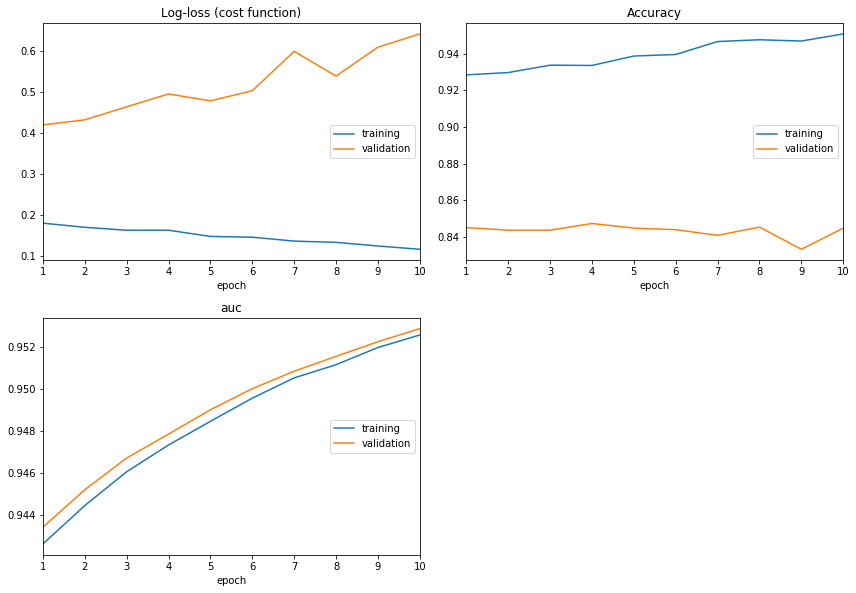

3541/3541 [==============================] - 3s 813us/step
Test loss: 0.6413683108575127
Test accuracy: 0.8446766450491978


In [23]:
batch_size = 128
model.fit(X_train, Y_train,  validation_data=(X_test, Y_test),
          epochs = 10, batch_size=batch_size, 
          callbacks = callbacks)
scores = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

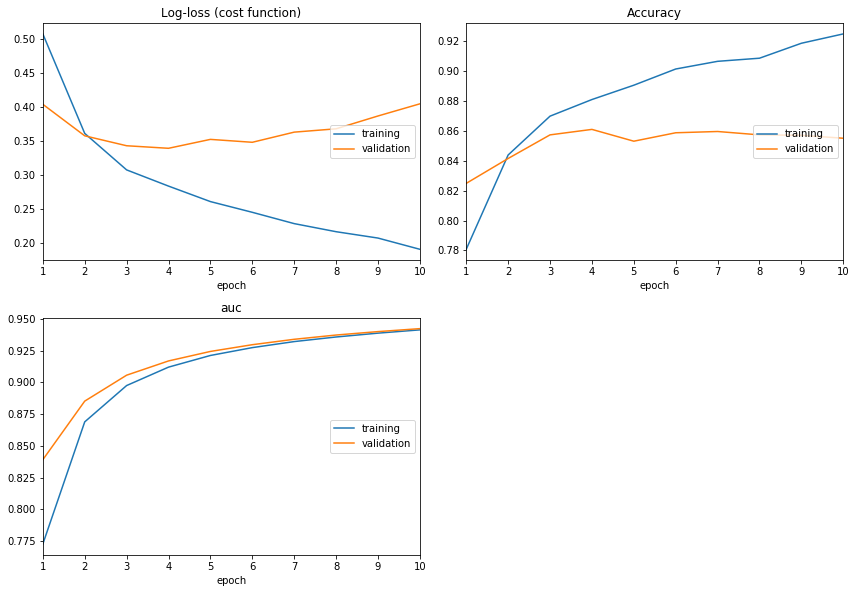

In [16]:
# Bidirectional LSTM
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.5))
model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))) 
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy', auc_roc])
batch_size = 64
model.fit(X_train, Y_train,  validation_data=(X_test, Y_test),
          epochs = 10, batch_size=128, 
          callbacks = callbacks)

In [22]:
scores = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

3541/3541 [==============================] - 3s 796us/step
Test loss: 0.40463303611528334
Test accuracy: 0.8551256707481528


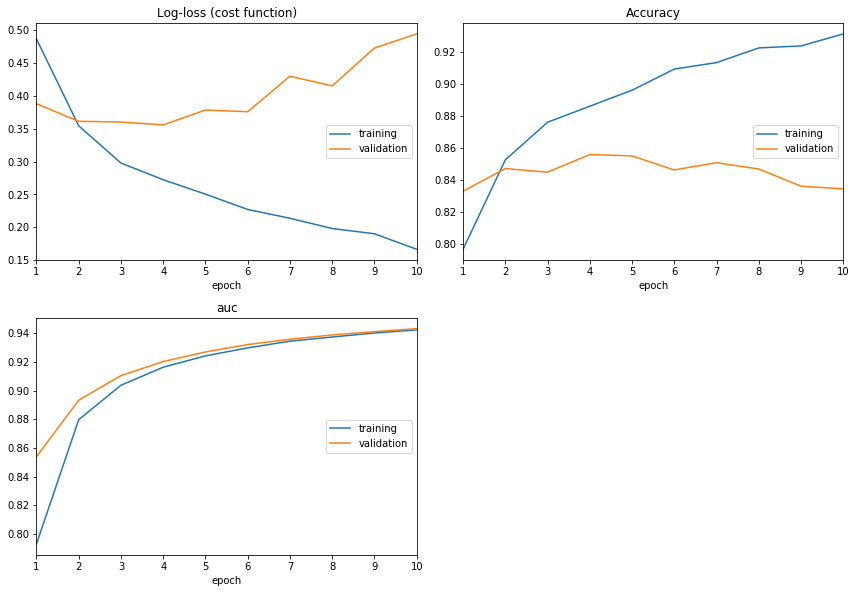

3541/3541 [==============================] - 2s 639us/step
Test loss: 0.4943764754622308
Test accuracy: 0.8345100254502145


In [25]:
# Bidirectional LSTM
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(GRU(lstm_out, dropout=0.2, recurrent_dropout=0.2))) 
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy', auc_roc])
batch_size = 64
model.fit(X_train, Y_train,  validation_data=(X_test, Y_test),
          epochs = 10, batch_size=128, 
          callbacks = callbacks)
scores = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [29]:
X.shape[1]

28

In [43]:
MAX_SEQUENCE_LENGTH = X.shape[1]
embedding_layer = Embedding(max_features,
        embed_dim,
        input_length = X.shape[1])

lstm_layer = LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2,return_sequences=True)

comment_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences= embedding_layer(comment_input)
x = lstm_layer(embedded_sequences)
x = Dropout(0.2)(x)
merged = Attention(MAX_SEQUENCE_LENGTH)(x)
merged = Dense(2, activation='relu')(merged)
merged = Dropout(0.4)(merged)
#merged = BatchNormalization()(merged)
preds = Dense(2, activation='sigmoid')(merged)
model = Model(inputs=[comment_input], \
        outputs=preds)
model.compile(loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy', auc_roc])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 28)                0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 28, 128)           256000    
_________________________________________________________________
lstm_18 (LSTM)               (None, 28, 196)           254800    
_________________________________________________________________
dropout_16 (Dropout)         (None, 28, 196)           0         
_________________________________________________________________
attention_10 (Attention)     (None, 196)               224       
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 394       
_________________________________________________________________
dropout_17 (Dropout)         (None, 2)                 0         
__________

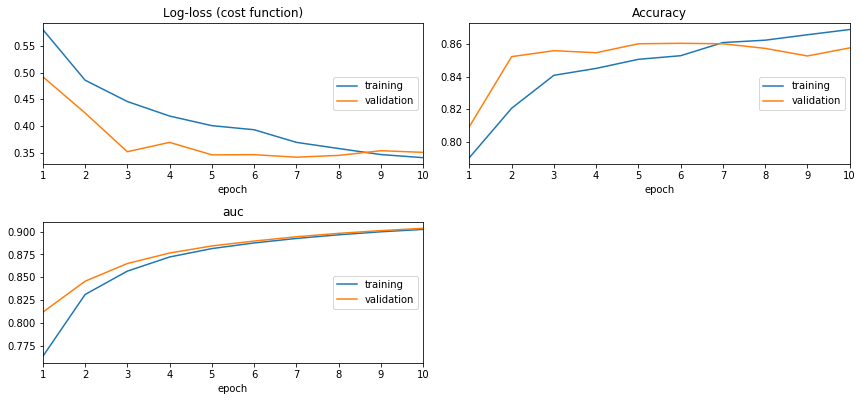

3541/3541 [==============================] - 2s 458us/step
Test loss: 0.3513035709088349
Test accuracy: 0.857667325631066


In [44]:
model.fit(X_train, Y_train,  validation_data=(X_test, Y_test),
          epochs = 10, batch_size=64, 
          callbacks = callbacks)
scores = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [27]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
        """
        self.supports_masking = True
        #self.init = initializations.get('glorot_uniform')
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        # eij = K.dot(x, self.W) TF backend doesn't support it

        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
    #print weigthted_input.shape
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        #return input_shape[0], input_shape[-1]
        return input_shape[0],  self.features_dim